# Crisp-DM process for Data Analysis
In this notebook, I have used Montreal Airbnb dataset to perform data analysis and answer the following questions.
* Which season is best for promotion and advertisement of Airbnb?
* Which Montreal area has best rooms available?
* Is there any similar type of listing available?

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Question 1: Which season is best for promotion and advertisement of Airbnb?
Here, I will use the calendar dataset to get the relevant attributes like available, date, listing_id to find the best season for promotion and advertisement on the basis of availability of rooms.

#### Reading Calendar Dataset

In [31]:
cal_df = pd.read_csv('./dataset/calendar.csv')
cal_df.head(5)

listing_id        date available   price adjusted_price  minimum_nights  \
0      164087  2019-03-11         t  $75.00         $75.00               1   
1        2078  2019-03-11         f  $38.00         $38.00               2   
2        2078  2019-03-12         f  $38.00         $38.00               2   
3        2078  2019-03-13         f  $38.00         $38.00               2   
4        2078  2019-03-14         f  $38.00         $38.00               2   

   maximum_nights  
0              25  
1               7  
2               7  
3               7  
4               7

#### Attributes in the dataframe

In [4]:
list(cal_df.columns)

['listing_id',
 'date',
 'available',
 'price',
 'adjusted_price',
 'minimum_nights',
 'maximum_nights']

#### Determining the sample size

In [5]:
cal_df['date'].min()

'2019-03-11'

In [6]:
cal_df['date'].max()

'2020-03-09'

#### Cleaning dataframe
As there is no null values in the dataframe, so we don't require data cleaning part

In [7]:
cal_df.isnull().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

In [38]:
# changing the datatype of date attribute
cal_df['date'] = pd.to_datetime(cal_df['date'])

# creating a season dataframe which only contains listing having no availability of rooms
season = cal_df[cal_df['available']=='f']

# grouping the date column to get the listing count
season = season.groupby('date')['listing_id'].count().reset_index()
season = season.rename(columns={'listing_id':'count'})

# creating month and day attribute
season['month'] = season['date'].dt.strftime('%b')
season['day'] = season['date'].dt.day

season.head()

date  count month  day
0 2019-03-11  17039   Mar   11
1 2019-03-12  15762   Mar   12
2 2019-03-13  15154   Mar   13
3 2019-03-14  14894   Mar   14
4 2019-03-15  15012   Mar   15

#### Plotting the season 

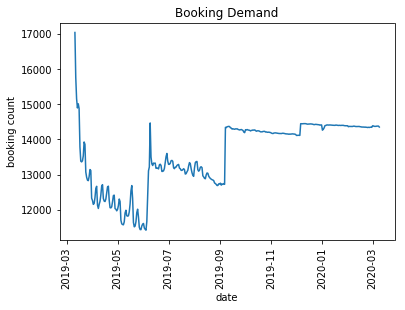

In [40]:
plt.plot(season['date'], season['count'])
plt.title('Booking Demand')
plt.xlabel('date')
plt.xticks(rotation='vertical')
plt.ylabel('booking count');

From above plot, I can conclude that the season becomes low around:
* late '2019-04' to late '2019-06'
* early '2019-07 to late '2019-09'  

I can't tell about the latter part as I don't know whether this is saturated value or not. I need more data to conclude from there.

#### Dividing seasons based on dips
Based on the above plot, I divided the whole season into 3 sub season based the the dips in the booking demand

In [42]:
# creating a weekday attribute for booking analysis on the daywise basis
season['weekday'] = season['date'].dt.weekday_name

# first dip cluster
sub_season_1 = season[(season['date']>='2019-03-11')& \
                      (season['date']<='2019-06-08')]

# second dip cluster
sub_season_2 = season[(season['date']>='2019-06-09')& \
                      (season['date']<='2019-09-06')]

# third dip cluster
sub_season_3 = season[(season['date']>='2019-09-07')& \
                      (season['date']<='2020-03-09')]

#### Plot for each cluster
Here, I'm using violinplot for analyzing the distribution of booking count per weekday

#### Sub-Season I

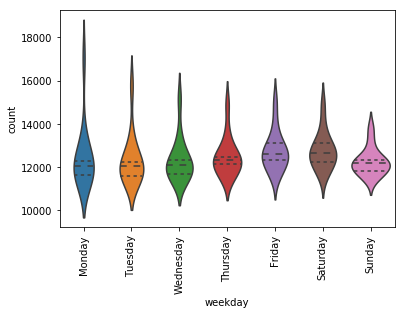

In [44]:
sns.violinplot(x='weekday', y='count', data=sub_season_1, inner = 'quartile')
plt.xticks(rotation='vertical')
plt.show()

#### Sub-Season II

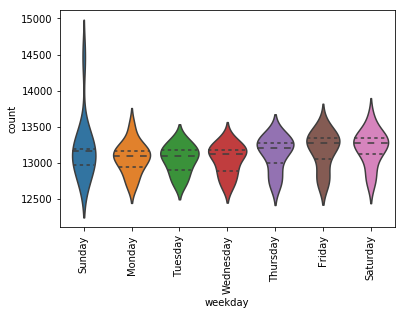

In [45]:
sns.violinplot(x='weekday', y='count', data=sub_season_2, inner = 'quartile')
plt.xticks(rotation='vertical')
plt.show()

#### Sub-Season III

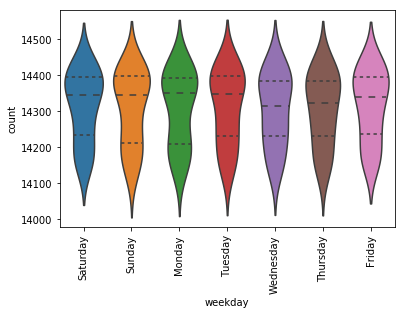

In [46]:
sns.violinplot(x='weekday', y='count', data=sub_season_3, inner = 'quartile')
plt.xticks(rotation='vertical')
plt.show()

#### Conclusion
In season I, we can see that the demand for bookings is low for ['Monday', 'Tuesday', 'Wednesday', 'Sunday']. In season II, the demand is low for ['Monday', 'Tuesday', 'Wednesday', 'Sunday']. In season III, it is low for ['Wednesday', 'Thursday'].

Overall, we need to focus on advertisements and promotions during the period of "2019-04" to "2019-09". During this period, we will target the audience only on ['Monday', 'Tuesday', 'Wednesday', 'Sunday'].

### Question 2: Which Montreal area has best rooms available?
Here, I'm using the listings dataset to take relevant features into account like host_is_superhost, zipcode, reviews_per_month for finding out the best area for best rooms.

#### Reading dataset

In [14]:
list_df = pd.read_csv('./dataset/listings.csv')
list_df.head()

id                         listing_url       scrape_id last_scraped  \
0   2078   https://www.airbnb.com/rooms/2078  20190311061246   2019-03-11   
1   2843   https://www.airbnb.com/rooms/2843  20190311061246   2019-03-11   
2  14584  https://www.airbnb.com/rooms/14584  20190311061246   2019-03-11   
3  29059  https://www.airbnb.com/rooms/29059  20190311061246   2019-03-11   
4  29061  https://www.airbnb.com/rooms/29061  20190311061246   2019-03-11   

                                                name  \
0                Central comfy close to Metro Laurie   
1                             Fabulous downtown room   
2  Spread Out in 1,200 Square Feet of Luxury in t...   
3                       Lovely studio Quartier Latin   
4                 Maison historique - Quartier Latin   

                                             summary  \
0  Centrally located in trendy Le Plateau.   Join...   
1  Come stay in this trendy area of downtown Mont...   
2  This stylish and spacious loft has modern artw...   
3  Lovely studio with 1 closed room, near everyth...   
4  Charmante maison au coeur du Quartier Latin et...   

                                               space  \
0  Centrally located  clean comfy furnished room ...   
1  Private individual room, double bed, desk, goo...   
2  It's artistic and tasteful with a modern touch...   
3  Lovely studio with 1 closed room, near everyth...   
4  Lovely historic house with plenty of period ch...   

                                         description experiences_offered  \
0  Centrally located in trendy Le Plateau.   Join...                none   
1  Come stay in this trendy area of downtown Mont...                none   
2  This stylish and spacious loft has modern artw...                none   
3  Lovely studio with 1 closed room, near everyth...                none   
4  Charmante maison au coeur du Quartier Latin et...                none   

                               neighborhood_overview  ... instant_bookable  \
0  Although my place is centrally located in Le P...  ...                t   
1  This area of St Henri is actually downtown Mon...  ...                t   
2  This chic apartment can be found in the Platea...  ...                f   
3  CENTRAL est le mot d'ordre : tout est proche. ...  ...                f   
4  Le quartier que vous découvrirez se nomme le Q...  ...                t   

  is_business_travel_ready          cancellation_policy  \
0                        f                     flexible   
1                        f                     moderate   
2                        f  strict_14_with_grace_period   
3                        f                     moderate   
4                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               6   
2                               1   
3                               2   
4                               2   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            3   
2                                            1   
3                                            2   
4                                            2   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            3   
2                                            0   
3                                            0   
4                                            0   

   calculated_hos

#### Attributes in the dataframe

In [15]:
list(list_df.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


From the above list, I think features like (host_is_superhost, zipcode, reviews_per_month) would be appropriate for finding out the insights related to best rooms.

#### Cleaning the dataframe

In [16]:
list_df[['host_is_superhost','zipcode', 'reviews_per_month']].isnull().sum()

host_is_superhost       1
zipcode               372
reviews_per_month    4275
dtype: int64

#### Dropping null values

In [17]:
list_df = list_df.dropna(subset=['host_is_superhost','zipcode', 'reviews_per_month'], axis=0)

#### Insights based on number of reviews

In [47]:
# grouping the zipcode to get the count of reviews_per_month for each zipcode
grouped_list_df = list_df.groupby('zipcode')['reviews_per_month'].count().sort_values(ascending=False).reset_index()

# taking only top 10 zipcodes having maximum reviews per month
grouped_list_df = grouped_list_df.head(10)
grouped_list_df = grouped_list_df.sort_values(by=['zipcode'])

# creating dataframe having zipcodes (top 10)
sub_list_df = list_df.loc[list_df['zipcode'].isin(grouped_list_df['zipcode'])]
sub_list_df = sub_list_df.sort_values(by=['zipcode'])

#### Visualization

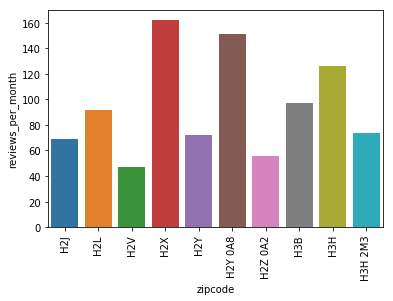

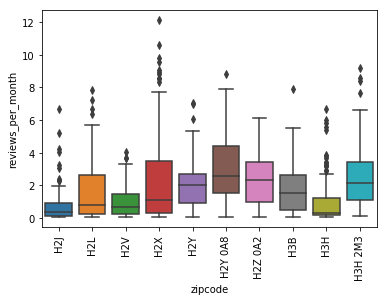

In [49]:
# visualizing the zipcodes with max reviews
sns.barplot(data=grouped_list_df, x='zipcode', y='reviews_per_month')
plt.titile('zipcodes with maximum reviews')
plt.xticks(rotation='vertical')
plt.show()

# visualizing the distribution of review score on each zipcodes
sns.boxplot(data=sub_list_df, x='zipcode', y='reviews_per_month')
plt.titile('distribution of review scores')
plt.xticks(rotation='vertical')
plt.show()

In this case, barplot will play a major role. We can conclude that 'H2X' has highest number of reviews according to both barplot and boxplot (most of the reviews is considered as outliers but it useful). 'H2Y 0A8' comes at second place and 'H3H' comes at third place for best rooms based on numbers of reviews. 

#### Insights based on total number of reviewed scores

In [50]:
# grouping the zipcode to get the sum of reviews score for each zipcode
grouped_list_df = list_df.groupby('zipcode')['reviews_per_month'].sum().sort_values(ascending=False).reset_index()

# taking only top 10 zipcodes having maximum sum of review score
grouped_list_df = grouped_list_df.head(10)
grouped_list_df = grouped_list_df.sort_values(by=['zipcode'])

# creating dataframe having zipcodes (top 10)
sub_list_df = list_df.loc[list_df['zipcode'].isin(grouped_list_df['zipcode'])]
sub_list_df = sub_list_df.sort_values(by=['zipcode'])

#### Visualization

In [ ]:
# visualizing the zipcodes with max review score
sns.barplot(data=grouped_list_df, x='zipcode', y='reviews_per_month')
plt.xticks(rotation='vertical')
plt.show()

# visualizing the distribution of review score on each zipcodes
sns.boxplot(data=sub_list_df, x='zipcode', y='reviews_per_month')
plt.xticks(rotation='vertical')
plt.show()

In this case, boxplot will play a major role. In barplot, it looks 'H2Y 0A8' has highest score, but in boxplot 'H2X' has some reviews having high scores. 'H2Y 0A8' has high number of good reviews. For (H2Y 0A6, H2Y 1S6), they have good number of good reviews. 

#### Insights based on number of superhost

In [51]:
# creating a dataframe where host is superhost only
new_list_df = list_df.loc[list_df['host_is_superhost'] == 't']

# grouping the zipcode to get the count of superhost available in a area.
grouped_list_df = new_list_df.groupby('zipcode')['host_is_superhost'].count().sort_values(ascending=False).reset_index()

# taking only top 10 zipcodes having maximum count of superhost
grouped_list_df = grouped_list_df.head(10)
grouped_list_df = grouped_list_df.sort_values(by=['zipcode'])

#### Visualization

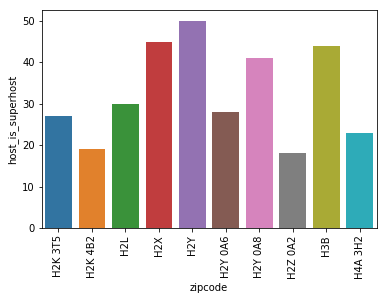

In [52]:
# visualizing the zipcodes with max number of superhost
sns.barplot(data=grouped_list_df, x='zipcode', y='host_is_superhost')
plt.xticks(rotation='vertical')
plt.show()

From above plot, we can say that (H2Y, H3B, H2X, H2Y 0A8, H2L) area have high number of superhost.

#### Conclusion
Overall, we cay that 
* H2X
* H2Y 0A8
* H3B  

are some of the zipcode areas where anyone can find best rooms based on customer reviews and superhost availability.

### Question 3: Is there any similar type of listing available?
Here again, I'm using listings dataset to take relevant features into account like listing_id, name, description for finding out the best area for best rooms.

#### Reading dataset

In [63]:
list_df = pd.read_csv('./dataset/listings.csv')
list_df.head()

id                         listing_url       scrape_id last_scraped  \
0   2078   https://www.airbnb.com/rooms/2078  20190311061246   2019-03-11   
1   2843   https://www.airbnb.com/rooms/2843  20190311061246   2019-03-11   
2  14584  https://www.airbnb.com/rooms/14584  20190311061246   2019-03-11   
3  29059  https://www.airbnb.com/rooms/29059  20190311061246   2019-03-11   
4  29061  https://www.airbnb.com/rooms/29061  20190311061246   2019-03-11   

                                                name  \
0                Central comfy close to Metro Laurie   
1                             Fabulous downtown room   
2  Spread Out in 1,200 Square Feet of Luxury in t...   
3                       Lovely studio Quartier Latin   
4                 Maison historique - Quartier Latin   

                                             summary  \
0  Centrally located in trendy Le Plateau.   Join...   
1  Come stay in this trendy area of downtown Mont...   
2  This stylish and spacious loft has modern artw...   
3  Lovely studio with 1 closed room, near everyth...   
4  Charmante maison au coeur du Quartier Latin et...   

                                               space  \
0  Centrally located  clean comfy furnished room ...   
1  Private individual room, double bed, desk, goo...   
2  It's artistic and tasteful with a modern touch...   
3  Lovely studio with 1 closed room, near everyth...   
4  Lovely historic house with plenty of period ch...   

                                         description experiences_offered  \
0  Centrally located in trendy Le Plateau.   Join...                none   
1  Come stay in this trendy area of downtown Mont...                none   
2  This stylish and spacious loft has modern artw...                none   
3  Lovely studio with 1 closed room, near everyth...                none   
4  Charmante maison au coeur du Quartier Latin et...                none   

                               neighborhood_overview  ... instant_bookable  \
0  Although my place is centrally located in Le P...  ...                t   
1  This area of St Henri is actually downtown Mon...  ...                t   
2  This chic apartment can be found in the Platea...  ...                f   
3  CENTRAL est le mot d'ordre : tout est proche. ...  ...                f   
4  Le quartier que vous découvrirez se nomme le Q...  ...                t   

  is_business_travel_ready          cancellation_policy  \
0                        f                     flexible   
1                        f                     moderate   
2                        f  strict_14_with_grace_period   
3                        f                     moderate   
4                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               6   
2                               1   
3                               2   
4                               2   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            3   
2                                            1   
3                                            2   
4                                            2   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            3   
2                                            0   
3                                            0   
4                                            0   

   calculated_hos

#### Attributes in the dataframe

In [64]:
list(list_df.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


#### Creating a sub dataframe
Here, I'm taking id, name and description features into account for the analysis

In [70]:
new_df = list_df[['id', 'name', 'description']]
new_df.head()

id                                               name  \
0   2078                Central comfy close to Metro Laurie   
1   2843                             Fabulous downtown room   
2  14584  Spread Out in 1,200 Square Feet of Luxury in t...   
3  29059                       Lovely studio Quartier Latin   
4  29061                 Maison historique - Quartier Latin   

                                         description  
0  Centrally located in trendy Le Plateau.   Join...  
1  Come stay in this trendy area of downtown Mont...  
2  This stylish and spacious loft has modern artw...  
3  Lovely studio with 1 closed room, near everyth...  
4  Charmante maison au coeur du Quartier Latin et...

#### Combining the attributes
I am combining the two features, so that I have to only apply tfidfvectorizer method on one feature only.

In [71]:
# combining the two features and coverting it to string datatype
new_df['content'] = new_df[['name', 'description']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

# dropping name and description attribute
new_df = new_df.drop(['name', 'description'], axis=1)

new_df.head()

/home/rajat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


id                                            content
0   2078  Central comfy close to Metro Laurie // Central...
1   2843  Fabulous downtown room // Come stay in this tr...
2  14584  Spread Out in 1,200 Square Feet of Luxury in t...
3  29059  Lovely studio Quartier Latin // Lovely studio ...
4  29061  Maison historique - Quartier Latin // Charmant...

#### Creating matrix of Tf-idf features
I will use TfidfVectorizer which will compute the bag of word count and tfidf values.

In [72]:
tf = TfidfVectorizer()
tf_matrix = tf.fit_transform(new_df['content'])

#### Calculating the similarity of documents using tf_matrix

In [73]:
cosine_similarities = linear_kernel(tf_matrix, tf_matrix)

#### Creating dictionary
Here the dictionary "results" is storing the similarity measures for each listing with other listings

In [75]:
results = {}
for idx, row in new_df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], new_df['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]
    
results

{2078: [(0.3566637943500123, 9233330),
  (0.3485325539758056, 26231187),
  (0.3476835048810102, 22772169),
  (0.3469111456323348, 23289343),
  (0.34474114722687804, 14093537),
  (0.34469167487966, 28782308),
  (0.3440291634232502, 14029175),
  (0.34304802664464806, 28357159),
  (0.34156373206184054, 20607753),
  (0.3397870521497734, 30594436),
  (0.3387387209952854, 19207505),
  (0.3357626953529824, 26010372),
  (0.33559742524582814, 11884412),
  (0.33364569082686824, 17861966),
  (0.3326211176031204, 7597435),
  (0.3320917099140021, 30888130),
  (0.33135926666649057, 27580405),
  (0.3310420918296242, 20427617),
  (0.3298281268339187, 21897602),
  (0.3292962366862977, 21896446),
  (0.3281895563438837, 4538099),
  (0.32788413415634365, 21382459),
  (0.32777148122366906, 25352441),
  (0.32742943366696325, 7885520),
  (0.3271185026332314, 3617172),
  (0.32687809136514645, 6781068),
  (0.3267650863707361, 21898116),
  (0.3264828155265391, 32084296),
  (0.32641619629447693, 4489619),
  (0.3

#### Function for recommending similar listing

In [76]:
def item(id):
    '''
    This function takes the listing id and returns the name and
    description of the listing
    '''
    name   = new_df.loc[new_df['id'] == id]['content'].tolist()[0].split(' // ')[0]
    desc   = new_df.loc[new_df['id'] == id]['content'].tolist()[0].split(' // ')[1][0:165] + '...'
    return [name, desc]

def recommend(item_id, num):
    '''
    This function takes out recommended listing ids and prints out
    recommended name and description of the listings 
    '''
    
    print('Recommending {} similar listing as {}\nDescription: {}\n\n\n'.format(str(num), item(item_id)[0], item(item_id)[1]))
    
    recs = results[item_id][:num]
    for rec in recs:
        print('Recommended: {}\nDescription: {}\n\n'.format(item(rec[1])[0], item(rec[1])[1]))

#### Trying out one example

In [77]:
recommend(item_id = 29061, num = 5)

Recommending 5 similar listing as Maison historique - Quartier Latin
Description: Charmante maison au coeur du Quartier Latin et proche de toutes les activités touristiques. Cette maison vous charmera par son caractère historique, elle fait partie...



Recommended: Maison de ville dans le Sud ouest de Montréal
Description: Belle maison ancestrale chaleureuse au coeur de Montréal dans le Sud ouest. Quartier paisible avec beaucoup d'arbres. À proximité du canal Lachine, du marché Atwater...


Recommended: maison en ville avec jardin
Description: C'est une maison pleine de charme, comportant un rez-de-chaussée  avec sous-sol, agrémentée d'un jardin très ensoleillé où il fait bon relaxer au son du jet d'eau et...


Recommended: cosy house- heart of Montreal- family friendly
Description: Gorgeous house in the heart of Montreal: Free private parking, view, AC, Wifi, in a quiet residential area with a large sunny backyard. A real peace of mind! Everyth...


Recommended: Chambre dans le quart

So, here is the 5 similar listing recommendation based on the cosine similarity